In [1]:
%load_ext autoreload
%autoreload 2
import dgl
import sys
import networkx as nx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../")
from src.convg import dgl_to_nx_graph
from src.balls import BallDistances
from src.baseline_models import train_knn, train_perceptron, train_rst, train_mv
from src.vcbases import retrieve_ball_bases, train_model, retrieve_hier_bases, retrieve_interval_bases, retrieve_lvc_bases_peeling, train_model_space_efficient
from src.utils import inject_noise

In [2]:
!wget -P data https://snap.stanford.edu/data/lastfm_asia.zip

--2024-03-14 09:51:06--  https://snap.stanford.edu/data/lastfm_asia.zip
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6527202 (6,2M) [application/zip]
Saving to: ‘data/lastfm_asia.zip’

lastfm_asia.zip     100%[===================>]   6,22M   319KB/s    in 25s     

2024-03-14 09:51:33 (253 KB/s) - ‘data/lastfm_asia.zip’ saved [6527202/6527202]



In [3]:
!unzip data/lastfm_asia.zip -d data/

Archive:  data/lastfm_asia.zip
   creating: data/lasftm_asia/
  inflating: data/lasftm_asia/lastfm_asia_edges.csv  
  inflating: data/lasftm_asia/lastfm_asia_target.csv  
  inflating: data/lasftm_asia/lastfm_asia_features.json  
  inflating: data/lasftm_asia/README.txt  


In [4]:
import csv
import os

lastfm_graph = nx.Graph()
with open(os.path.join("./data/lasftm_asia", "lastfm_asia_edges.csv")) as f:
    csv_reader = csv.reader(f)
    header = next(csv_reader)
    for line in csv_reader:
        u, v = map(int, (line[0],line[1]))
        lastfm_graph.add_edge(u, v)
with open(os.path.join("./data/lasftm_asia", "lastfm_asia_target.csv")) as f:
    next(f)
    for line in f:
        node, label = map(int, line.strip().split(','))
        lastfm_graph.nodes[node]['label'] = label
for e in lastfm_graph.edges:
    lastfm_graph.edges[e]['capacity'] = 1.0
print(lastfm_graph)

Graph with 7624 nodes and 27806 edges


In [5]:
largest_cc = max(nx.connected_components(lastfm_graph), key=len)
testg = lastfm_graph.subgraph(largest_cc)
testg_labels = [testg.nodes[node]['label'] for node in testg.nodes]

# Relable nodes in incremental order
testg = nx.relabel_nodes(testg, {n: i for i, n in enumerate(testg.nodes())})
for e in testg.edges:
    testg.edges[e]['capacity'] = 1.0
print(testg)
testg.remove_edges_from(nx.selfloop_edges(testg))
print(testg)

Graph with 7624 nodes and 27806 edges
Graph with 7624 nodes and 27806 edges


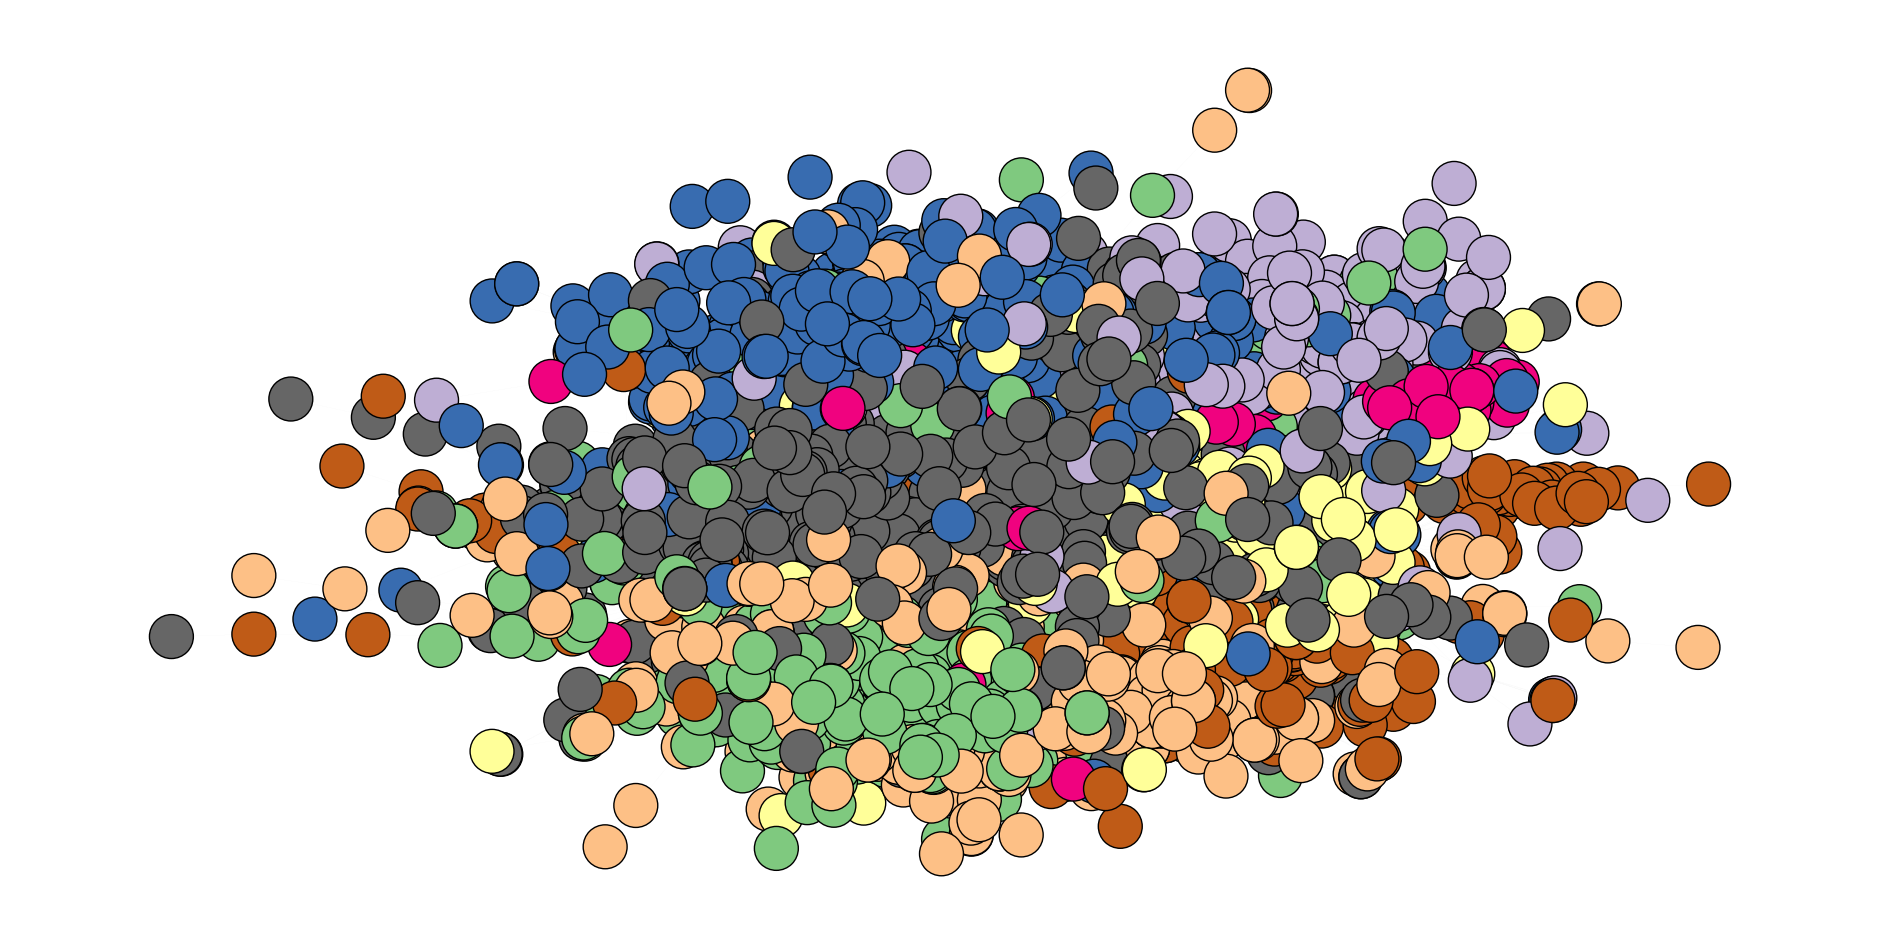

In [6]:
from src.utils import render_graph

render_graph(testg, path='./lastfm.pdf')

In [7]:
nx.write_gexf(testg, "./lastfm.gexf")

In [6]:
import time
tmp = time.time()
balls = BallDistances(testg, initialize_sp=False, initialize_edp=False, initialize_pinv=False, disable = True)
tolerance = 0.01
#d1_bases, n2b_d1 = retrieve_ball_bases(testg, balls.d1_ball_distance, disable=False)
#d2_bases, n2b_d2 = retrieve_ball_bases(testg, balls.d2_ball_distance, disable=False, log_balls = True)
#dinf_bases, n2b_dinf = retrieve_ball_bases(testg, balls.dinf_ball_distance, disable=False)
lvc_bases, n2b_lvc = retrieve_lvc_bases_peeling(testg,disable=False)
#int_bases, n2b_int = retrieve_interval_bases(testg, disable = False)
tmp = time.time() - tmp
print("RETRIEVING BALLS: ", tmp)

Computing node to base:   0%|          | 0/7624 [00:00<?, ?it/s]

RETRIEVING BALLS:  9.315595626831055


In [10]:
%%time
from src.utils import relabel_graph, create_noise_graph, create_noise_graph_perc
import random
import time
from tqdm.auto import tqdm
from collections import defaultdict
from src.bandits import train_bandit
from src.GABA import train_gaba
from src.contextualsimilarity import train_cont
from src.exp3 import train_exp3

tmp_train = time.time()

epochs = 1
seed_list = random.choices(list(range(1000)), k = 10)
lastfm_seeds = 5
NOISE_LABELS = 3
PERC_NOISE_FOREGROUND = 0.2

rows_df = []
rows_names = []

labels_set = set([testg.nodes[n]['label'] for n in testg.nodes])
random.seed(32)
rsl = [set(random.sample(range(len(labels_set)), NOISE_LABELS)) for _ in range(lastfm_seeds)]

plt_np_arr = {
    frozenset(r) : dict() for r in rsl
}
print(rsl)
###############################################################
for random_set_label in tqdm(rsl, desc="Lastfm_seeds..."):
    ## Create the graph from cora
    testg = lastfm_graph.subgraph(largest_cc)
    # Relable nodes in incremental order
    testg = nx.relabel_nodes(testg, {n: i for i, n in enumerate(testg.nodes())})
    labels_set = set([testg.nodes[n]['label'] for n in testg.nodes])
    for e in testg.edges:
        testg.edges[e]['capacity'] = 1.0
    print("Making noisy the labels: ", random_set_label)
    testg = create_noise_graph(testg, random_set_label)
    testg = relabel_graph(testg)
    #############################################################
    #bases_list = [(d1_bases, n2b_d1, "D1"), 
    #              (d2_bases, n2b_d2, "D2"), 
    #              (dinf_bases, n2b_dinf, "D-INF"), 
    #              (lvc_bases, n2b_lvc, "LVC"), 
    #              (int_bases, n2b_int, "INT")]
    bases_list = [(lvc_bases, n2b_lvc, "LVC")]
    # Squared number of nodes (at least 2 times for each node)
    T = len(testg.nodes)*10
    print(T)
    
    curr_labels_set = set([testg.nodes[n]['label'] for n in testg.nodes])
    K_classes = len(curr_labels_set) - 1
    res_list = defaultdict(lambda : [])
    res_plot = defaultdict(lambda : [])
    for seed in tqdm(seed_list, desc="Epochs"):    
        ##############################################################################
        ######################### TRAINING ###########################################
        ##############################################################################
        loss_perc = .8
        verbose = False
        for base, n2b, name in bases_list:
            res, _ = train_bandit(testg, 
                base,
                n2b,
                T,
                K_classes,
                loss_percentage = loss_perc,
                seed = seed,
                verbose = verbose,
                name=name,
                disable_tqdm_train = True, debug = True)
            res_list[name] += [res[0]/T]
            res_plot[name] += [np.array(res[1])]
            
        res_gaba, _ = train_gaba(
            testg, 
            T, 
            K_classes + 1, 
            eta = 0.07,
            seed = seed, 
            loss_percentage = loss_perc,
            debug = True, verbose = verbose, disable_tqdm_train = True)
        res_list["GABA"] += [res_gaba[0]/T]
        res_plot["GABA"] += [np.array(res_gaba[1])]
        
        res_cbs, _ = train_cont(
            testg, 
            T, 
            K_classes + 1, 
            seed = seed, 
            loss_percentage = loss_perc,
            debug = True, verbose = verbose, disable_tqdm_train = True)
        res_list["CBSim"] += [res_cbs[0]/T]
        res_plot["CBSim"] += [np.array(res_cbs[1])]
        
        res_exp3, _ = train_exp3(
            testg, 
            T, 
            K_classes + 1, 
            seed = seed, 
            loss_percentage = loss_perc,
            debug = True, verbose = verbose, disable_tqdm_train = True)
        res_list["EXP3"] += [res_exp3[0]/T]
        res_plot["EXP3"] += [np.array(res_exp3[1])]

    rate_list = [np.mean(r_l) for _,r_l in res_list.items()]
    std_list = [np.std(r_l) for _,r_l in res_list.items()]
    
    for lab, plot in res_plot.items(): 
        plt_np_arr[frozenset(random_set_label)][lab] = plot
    
    rows_df += [rate_list]
    rows_names += [f'Mean{random}']
    rows_df += [std_list]
    rows_names += [f'Std{random_set_label}']
    
    ###################################################

tmp_train = time.time() - tmp_train

#base_model_names = res_list.keys()
#res_df = pd.DataFrame(columns=base_model_names)
#for ind,row in enumerate(rows_df):
#    res_df.loc[ind] = row
#res_df.index = rows_names
#
#res_df

[{2, 4, 6}, {9, 15, 7}, {0, 1, 3}, {16, 17, 10}, {16, 1, 15}]


Lastfm_seeds...:   0%|          | 0/5 [00:00<?, ?it/s]

Making noisy the labels:  {2, 4, 6}
76240


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Making noisy the labels:  {0, 1, 3}
76240


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Making noisy the labels:  {16, 17, 10}
76240


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Making noisy the labels:  {16, 1, 15}
76240


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 16h 18min 9s, sys: 4.31 s, total: 16h 18min 14s
Wall time: 16h 18min 12s


In [11]:
input_list_string = [str(r) for r in rsl]

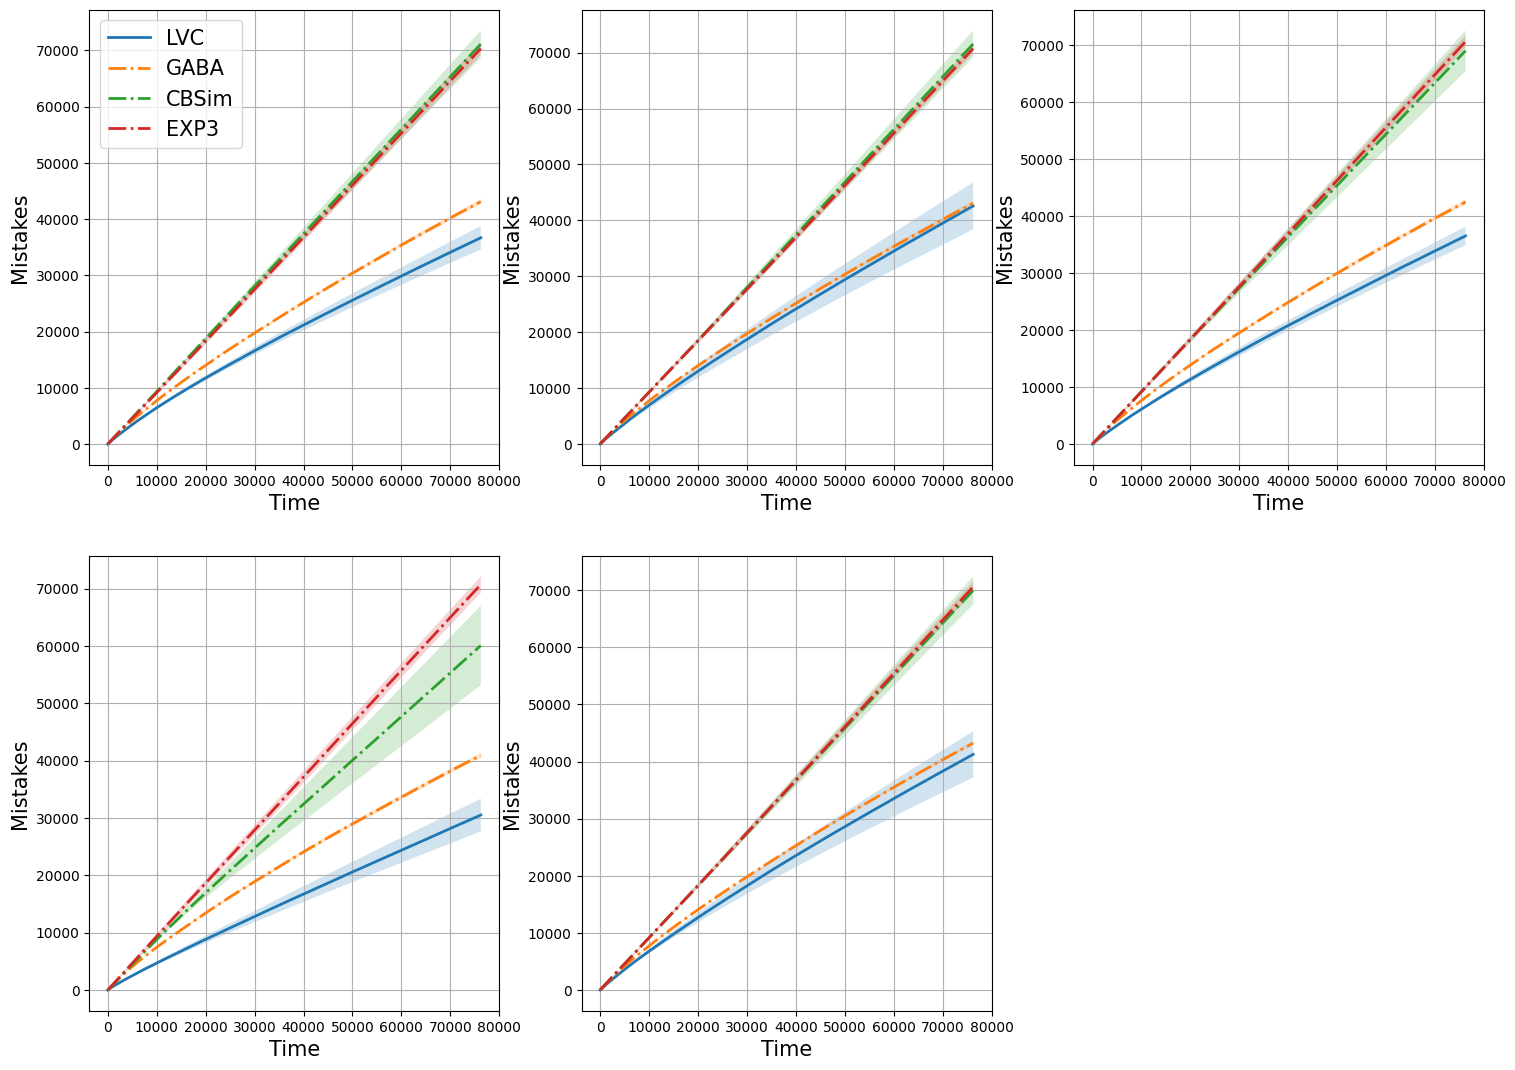

In [18]:
from src.utils import render_plot_CI

test_loaded_plot = (input_list_string, plt_np_arr)

render_plot_CI('LastFM', test_loaded_plot,2,3, figx=18, figy=13, save_fig=True, path = './results/lastFM/all_lastfm.pdf')

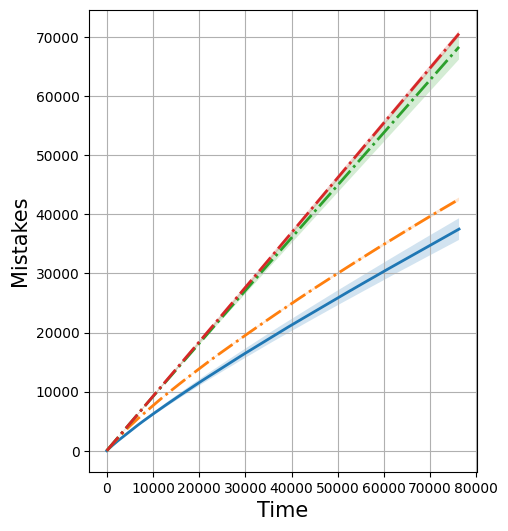

In [21]:
baselines = ['EXP3', 'GABA', 'CBSim']
fig, axs = plt.subplots(1, 1, figsize=(5, 6))

res = {
        lab : [] for lab, item in plt_np_arr[frozenset([2, 4, 6])].items()
    }
for _, d in plt_np_arr.items():
    for label, value in d.items():
        res[label] += value
        
for sub_key, sub_data in res.items():
    if sub_key in baselines:
        line =  'dashdot'
    else:
        line = 'solid'

    plot_data = np.mean(sub_data, axis = 0)
    axs.plot(plot_data, label=sub_key, linestyle = line, lw = 2)

    conf_int = np.std(sub_data, axis = 0) / np.sqrt(len(sub_data)) * 1.96
    axs.fill_between(np.arange(len(plot_data)), plot_data - conf_int, plot_data + conf_int, alpha=0.2)
axs.set_xlabel('Time',fontsize=15)
axs.set_ylabel('Mistakes',fontsize=15) 
axs.grid()